# Lab:  Nonlinear Least Squares for Modeling Materials

Nonlinear least squares (NLLS) is a widely-used method for modeling data.  In NLLS, we wish to fit a model of the form,

     yhat = g(x,w)
     
where `w` is a vector of paramters and `x` is the vector of predictors.  We find `w` by minimizing a least-squares function 

     f(w) = \sum_i (y_i - g(x_i,w))^2
     
where the summation is over training samples `(x_i,y_i)`.  This is similar to linear least-squares, but the function `g(x,w)` may not be linear in `w`.  In general, this optimization has no closed-form expression.  So numerical optimization must be used.  

In this lab, we will implement gradient descent on NLLS in a problem of physical modeling of materials.  Specifically, we will estimate parameters for expansion of copper as a function of temperature using a real dataset.  In doing this lab, you will learn to:
* Set up a nonlinear least squares as an unconstrained optimization function
* Compute initial parameter estimates for a simple rational model
* Compute the gradients of the least squares objective
* Implement gradient descent for minimizing the objective
* Implement momentum gradient descent
* Visualize the convergence of the algorithm

We first import some key packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data

The NIST agency has an excellent [nonlinear regression website](https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml) that has several datasets for nonlinear regression problems.  In this lab, we will use the data from a NIST study involving the thermal expansion of copper. The response variable is the coefficient of thermal expansion, and the predictor variable is temperature in degrees kelvin.  

> Hahn, T., NIST (1979), Copper Thermal Expansion Study.  (unpublished}

You can download the data as follows.

In [2]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['x0','y0','dummy'])
df.head()

,x0,y0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


Extract the `x0` and `y0` into arrays.  Rescale, `x0` and `y0` to values between `0` and `1` by dividing `x0` and `y0` by the maximum value.  Store the scaled values in vectors `x` and `y`.  The rescaling will help with the conditioning of the fitting.  Plot, `y` vs. `x`. 

(236,)
(236,)


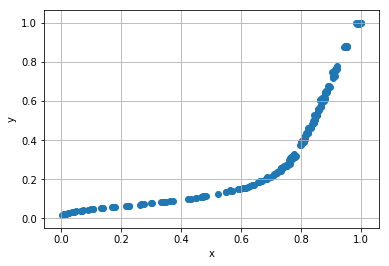

In [3]:
# TODO
x0 = np.array(df["x0"])
y0 = np.array(df["y0"])
x = x0/np.max(x0)
y = y0/np.max(y0)
print(x.shape)
print(y.shape)
plt.scatter(x,y)
plt.xlabel("x")
plt.ylabel("y")
plt.grid()


To make the problem a little more challenging, we will add some noise.  Add random Gaussian noise with mean 0 and std. dev = 0.05 to `y`.  Store the noisy results in `yn`. You can use the `np.random.normal()` function to add Gaussian noise. Plot `yn` vs. `x`.

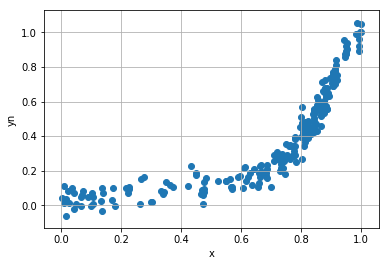

In [4]:
# TODO
yn=y+np.random.normal(0,0.05,len(x))
plt.scatter(x,yn)
plt.xlabel("x")
plt.ylabel("yn")
plt.grid()


Split the data `(x,yn)` into training and test.  Let `xtr,ytr` be training data and `xts,yts` be the test data.  You can use the `train_test_split` function.  Set `test_size=0.33` so that 1/3 of the samples are held out for test.

In [5]:
from sklearn.model_selection import train_test_split
x=x.reshape(-1,1)
y=y.reshape(-1,1)
yn=yn.reshape(-1,1)
# TODO
xtr, xts, ytr, yts = train_test_split(x,yn,test_size=0.33)

## Initial Fit for a Rational Model

The [NIST website](https://www.itl.nist.gov/div898/strd/nls/data/hahn1.shtml) suggests using a *rational* model of the form,

      yhat = (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
      
with `d=3`.  The model parameters are `w = [a[0],...,a[d],b[0],...,b[d-1]]` so there are `2d+1` parameters total.    Complete the function below that takes vectors `w` and `x` and predicts a set of values `yhat` using the above model.
   

In [6]:
def predict(w,x):
    
    # Get the length
    d = (len(w)-1)//2
    
    # TODO.  Extract a and b from w
    a = w[0:d+1]
    b = w[d+1:2*d+2]
    b=np.append(1,b)
    # TODO.  Compute yhat.  You may use the np.polyval function
    # But, remember you must flip the order the a and b
    yhat = (np.polyval(np.flip(a),x))/(np.polyval(np.flip(b),x))
    return yhat


When we fit with a nonlinear model, most methods only get convergence to a local minima.  So, you need a good initial condition.  For a rational model, one way to get is to realize that if:


    y ~= (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
    
Then:

    y ~= a[0] + a[1]*x + ... + a[d]*x^d - b[0]*x*y + ... - b[d-1]*x^d*y.
    
So, we can solve for the the parameters `w = [a,b]` from linear regression of the predictors,

    Z[i,:] = [ x[i], ... , x[i]**d, y[i]*x[i], ... , y[i}*x[i]**d ] 

In [7]:
d = 3

# TODO.  Create the transformed feature matrix
Z = np.zeros((xtr.shape[0],2*d))
for i in range(0,d):
    Z[:,i]=xtr[:,0]**(i+1)
    Z[:,i+d]=ytr[:,0]*xtr[:,0]**(i+1)
# TODO.  Fit with parameters with linear regression
regr1 = LinearRegression()
regr1.fit(Z,ytr)
regr1.coef_[0,d:2*d]=-1*regr1.coef_[0,d:2*d]
# TODO
# Extract the parameters from regr.coef_ and regr.intercept_ and store the parameter vector in winit
winit = np.append(regr1.intercept_,regr1.coef_)
print(winit)

[ 2.35261079e-02  7.31124499e-03 -3.50147116e-01  3.65284733e-01
 -5.16804763e+00  7.47602965e+00 -3.26896160e+00]


Now plot the predicted values of the `yhat` vs. `x` using your estimated parameter `winit` for 1000 values `x` in `[0,1]`.  On the same plot, plot `yts` vs. `xts`.  You will see that you get a horrible fit.

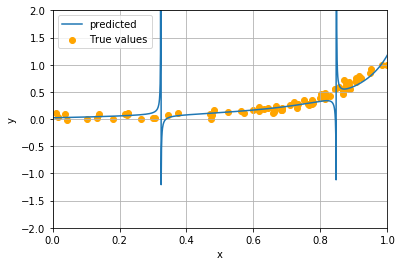

In [8]:
# TODO
xp=np.linspace(0,1,num=1000)

yhat=predict(winit,xp)

plt.figure(num=2)
plt.plot(xp,yhat)
plt.scatter(xts,yts,color="orange")
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.axis([0,1,-2,2])
plt.legend(["predicted","True values"])

The reason the previous fit is poor is that the denominator in `yhat` goes close to zero.   To avoid this problem, we can use Ridge regression, to try to keep the parameters close to zero.  Re-run the fit above with `Ridge` with `alpha = 1e-3`. You should see you get a reasonable, but not perfect fit.

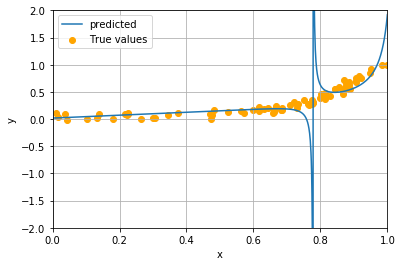

In [9]:
# TODO.  Fit with parameters with linear regression
regr2 = Ridge(alpha=1e-3)
regr2.fit(Z,ytr)
regr2.coef_[0,d:2*d]=-1*regr2.coef_[0,d:2*d]
# TODO
# Extract the parameters from regr.coef_ and regr.intercept_
winit = np.append(regr2.intercept_,regr2.coef_)

# TODO
# Plot the results as above.
xp=np.linspace(0,1,num=1000)

yhat=predict(winit,xp)

plt.figure(num=3)
plt.plot(xp,yhat)
plt.scatter(xts,yts,color="orange")
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.axis([0,1,-2,2])
plt.legend(["predicted","True values"])

## Creating a Loss Function

We can now use gradient descent to improve our initial estimate.  Complete the following function to compute

    f(w) = 0.5*\sum_i (y[i] - yhat[i])^2
    
and `fgrad`, the gradient of `f(w)`.

In [10]:
def feval(w,x,y):

    # TODO.  Parse w
    len=np.array(w.shape)
    d=int(0.5*(len[0]-1)) #notice d=3
    a=w[0:d+1]
    b=np.flip(w[d+1:2*d+1])
    b=np.flip(np.append(b,1))

    # TODO.  Znum[i,j] = x[i]**j
    
    Znum=np.zeros((x.shape[0],d+1))
    
    for j in range(0,d+1):
        Znum[:,j]=a[j]*x[:,0]**j

    # TODO    
    Zden=np.zeros((x.shape[0],d+1))
    
    for j in range(0,d+1):
        Zden[:,j]=b[j]*x[:,0]**(j)
    
    # TODO.  Compute yhat 
    # Compute the numerator and denominator   
    Num=np.sum(Znum,axis=1)
    Num=Num.reshape(-1,1)
    Den=np.sum(Zden,axis=1)
    Den=Den.reshape(-1,1)
    yhat=Num/Den
    
    # TODO.  Compute loss
    yerr=y-yhat
    f=0.5*np.sum(yerr**2)
    
    # TODO.  Compute gradients
    dfw0=-np.sum(yerr/Den)
    dfw1=-np.sum(yerr*x/Den)
    dfw2=-np.sum(yerr*(x**2)/Den)
    dfw3=-np.sum(yerr*(x**3)/Den)
    dfw4=-np.sum(yerr*Num*x/(Den**2))
    dfw5=-np.sum(yerr*Num*(x**2)/(Den**2))
    dfw6=-np.sum(yerr*Num*(x**3)/(Den**2))

    
    fgrad=np.array([dfw0,dfw1,dfw2,dfw3,dfw4,dfw5,dfw6])
    return f, fgrad

Test the gradient function:
* Take `w0=winit` and compute `f0,fgrad0 = feval(w0,xtr,ytr)`
* Take `w1` very close to `w0` and compute `f1,fgrad1 = feval(w1,xtr,ytr)`
* Verify that `f1-f0` is close to the predicted value based on the gradient.

In [11]:
delta=1e-6
w0=winit
f0, fgrad0=feval(w0,xtr,ytr)
w1=w0+delta

f1,fgrad1=feval(w1,xtr,ytr)
print('f1-f0 = ',f1-f0)
delta_vector=np.ones((w0.shape[0],1))*delta
fpred=np.sum(fgrad0*delta)
print('fpred = ',fpred)
diff=np.abs(fpred-f1+f0)
print('diff  = ',diff)


f1-f0 =  1.503983131219087
fpred =  -2.1001832602249895
diff  =  3.604166391444082


## Implement gradient descent

We will now try to minimize the loss function with gradient descent.  Using the function `feval` defined above, implement gradient descent.  Run gradient descent with a step size of `alpha=1e-6` starting at `w=winit`.  Run it for `nit=10000` iterations.  Compute `fgd[it]`= the objective function on iteration `it`.  Plot `fgd[it]` vs. `it`.  

You should see that the training loss decreases, but it still hasn't converged after 10000 iterations.

(10000,)


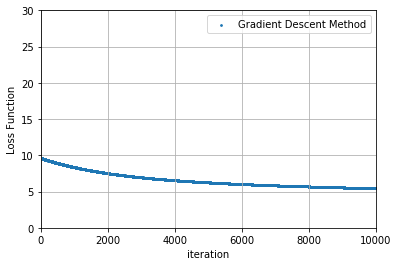

In [13]:
# TODO
# fgd = ...
nit = 10000
step = 1e-6
w0=winit
fgd=[]
for it in range(nit):
    f0,fgrad0=feval(w0,xtr,ytr)
    w0=w0-step*fgrad0
    fgd=np.append(fgd,f0)
    
it=np.arange(0,nit)
plt.figure(num=4)
plt.scatter(it,fgd,s=3)
plt.grid()
plt.axis([0,10000,0,30])
plt.xlabel('iteration')
plt.ylabel('Loss Function')
plt.legend(['Gradient Descent Method'])
print(fgd.shape)

Now, try to get a faster convergence with adaptive step-size using the Armijo rule. Implement the gradient descent with adaptive step size.  Let `fadapt[it]` be the loss function on iteration `it`.  Plot `fadapt[it]` and `fgd[it]` vs. `it` on the same graph.  You should see a slight improvement, but not much.

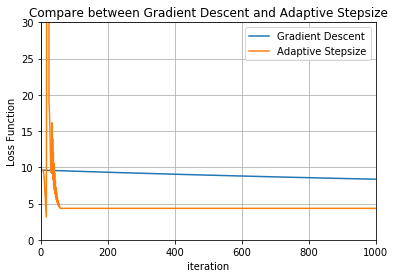

In [15]:
# TODO
# fadapt = ...
nit = 10000
n=1000
step = 1e-6  # Initial step

w_gd=winit
f0_gd,fgrad0_gd=feval(w_gd,xtr,ytr)
fgd_gd=np.array([f0_gd])

for it in range(1,nit):
    w_gd=w_gd-step*fgrad0_gd
    f1_gd,fgrad1_gd=feval(w_gd,xtr,ytr)
    fgd_gd=np.append(fgd_gd,f1_gd)
    f0_gd=f1_gd
    fgrad0_gd=fgrad1_gd

nit_as=n
step_as=1e-6
w_as=winit
f0_as,fgrad0_as=feval(w_as,xtr,ytr)
fadapt=[f0]
c=0.5
beta=2
for it in range(1,nit_as):
    w_as=w_as-step_as*fgrad0_as
    f1_as,fgrad1_as=feval(w_as,xtr,ytr)
    if f0_as-f1_as>=c*step_as*np.linalg.norm(fgrad0_as):
        step_as=beta*step_as
    else:
        step_as=step_as/beta
    fadapt=np.append(fadapt,f1_as)
    f0_as=f1_as
    fgrad0_as=fgrad1_as

it=np.arange(0,nit)
it_as=np.arange(0,nit_as)
plt.figure(num=5)
plt.plot(it,fgd_gd)
plt.plot(it_as,fadapt)
plt.axis([0,n,0,30])
plt.grid()
plt.xlabel('iteration')
plt.ylabel('Loss Function')
plt.title('Compare between Gradient Descent and Adaptive Stepsize')
plt.legend(['Gradient Descent','Adaptive Stepsize'])

Using he final estimate for `w` from the adaptive step-size plot the predicted values of the `yhat` vs. `x` usfor 1000 values `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the initial parameter `w=winit`.  Also, plot `yts` vs. `xts`.  You should see that gradient descent was able to improve the estimat slightly, although the initial estimate was not too bad.

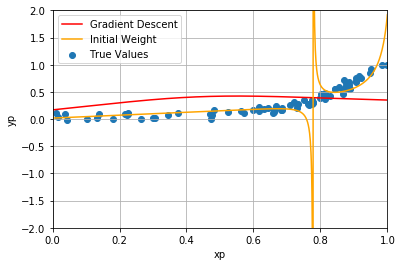

In [16]:
# TODO
# xp = np.linspace(...)
# yhat = ...
# plot(...)
xp=np.linspace(0,1,num=1000)
yhat_fina=predict(w0,xp)
yhat_init=predict(winit,xp)

plt.plot(xp,yhat_fina,color="red")
plt.plot(xp,yhat_init,color="orange")
plt.scatter(xts,yts)
plt.axis([0,1,-2,2])
plt.grid()
plt.xlabel("xp")
plt.ylabel("yp")
plt.legend(["Gradient Descent","Initial Weight","True Values"])

## Momentum Gradient Descent

This section is bonus.

One way to improve gradient descent is to use *momentum*.  In momentum gradient descent, the update rule is:

    f, fgrad = feval(w,...)
    z = beta*z + fgrad
    w = w - step*z
    
This is similar to gradient descent, except that there is a second order term on the gradient.  Implement this algorithm with `beta = 0.99` and `step=1e-5`.   Compare the convergence of the loss function with gradient descent.  

In [17]:
# TODO
nit = 1000
step = 1e-5
beta = 0.99

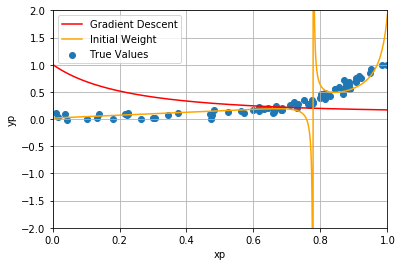

In [19]:
# TODO
# plot yhat vs. x
w0=winit
fgd=[]
for it in range(nit):
    f0,fgrad0=feval(w0,xtr,ytr)
    w0=w0-step*fgrad0
    fgd=np.append(fgd,f0)
    
it=np.arange(0,nit)
w_gd=winit
f0_gd,fgrad0_gd=feval(w_gd,xtr,ytr)
fgd_gd=np.array([f0_gd])

for it in range(1,nit):
    w_gd=w_gd-step*fgrad0_gd
    f1_gd,fgrad1_gd=feval(w_gd,xtr,ytr)
    fgd_gd=np.append(fgd_gd,f1_gd)
    f0_gd=f1_gd
    fgrad0_gd=fgrad1_gd

nit_as=1000
step_as=1e-5
w_as=winit
f0_as,fgrad0_as=feval(w_as,xtr,ytr)
fadapt=[f0]
c=0.5
beta = 0.99
for it in range(1,nit_as):
    w_as=w_as-step_as*fgrad0_as
    f1_as,fgrad1_as=feval(w_as,xtr,ytr)
    if f0_as-f1_as>=c*step_as*np.linalg.norm(fgrad0_as):
        step_as=beta*step_as
    else:
        step_as=step_as/beta
    fadapt=np.append(fadapt,f1_as)
    f0_as=f1_as
    fgrad0_as=fgrad1_as

it=np.arange(0,nit)
it_as=np.arange(0,nit_as)

xp=np.linspace(0,1,num=1000)
yhat_fina=predict(w0,xp)
yhat_init=predict(winit,xp)

plt.plot(xp,yhat_fina,color="red")
plt.plot(xp,yhat_init,color="orange")
plt.scatter(xts,yts)
plt.axis([0,1,-2,2])
plt.grid()
plt.xlabel("xp")
plt.ylabel("yp")
plt.legend(["Gradient Descent","Initial Weight","True Values"])

## Beyond This Lab
In this lab, we have just touched at some of the ideas in optimization.  There are several other important algorithms that you can explore:
* [Levenberg-Marquardt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) method for non-linear least squares
* Newton's method
* More difficult non-linear least squares problems.